# Skip-Gram using Tensorflow.
I've build and trained a skip-gram model on Alice in Wonderland Novel using Tensorflow.

<b>Author:</b> Yash Sharma <br />
<b>Created On:</b> 28th August, 2017

<b>Reference</b>: [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/word2vec)

In [1]:
# Libraries
import math
import collections
import numpy as np
import io
import random
import tensorflow as tf
from sklearn.manifold import TSNE
from matplotlib import pylab

## Loading the Dataset

In [2]:
# Open the File and read the content of the file and store them in words variable
words = io.open('11-0.txt', 'r').read().split()
print ('Data Size:', len(words))

Data Size: 26442


## Building the Dictionary

We would create 2 Dictionaries.
    1. word2index: To convert each word in our vocabulary to a index (a number)
    2. index2word: To convert words bach to thier original form 
    
Also, words that are rarer and doesn't occur much in our dataset we would simply replace them with UNK Token.

In [3]:
# Size of the Vocabulary
vocabulary_size = len(words)

def build_dataset(words):
    # Create a count list and
    # Set the first Element to be UNK and it's count as -1
    count = [['UNK', -1]]
    
    # Add the most common words with thier total count (occurence)
    # into the count list.
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    
    # Variable to hold the dictionary
    word2index = dict()
    
    # for each word in count list
    for word, _ in count:
        # set the dictionary as
        # Key: Word & Value: the len of the dictionary at that moment.
        # This is just a way of giving index to each word 
        word2index[word] = len(word2index)
        
    # A new List.    
    data = list()
    unk_count = 0
    
    # for each word in our vocabulary.
    for word in words:
        # if the word is alreay in the dictionary
        if word in word2index:
            # get the index of that word
            index = word2index[word]
            
        # if word is not in the dictionary
        else:
            # set the index as zero and increase the UNK count by 1
            index = 0;
            unk_count += 1
            
        # Append or add the index to the data list
        data.append(index)
        
    # Set the UNK counter in our count list to the number of UNK words
    count[0][1] = unk_count
    
    # index to word dictionary
    index2word = dict(zip(word2index.values(), word2index.keys()))
    
    return data, count, word2index, index2word

In [4]:
data, count, word2index, index2word = build_dataset(words)

print ("Most Common Words (+UNK)", count[:5])
print ("Sample Data:", data[:10])

Most Common Words (+UNK) [['UNK', 0], ('the', 1507), ('and', 714), ('to', 703), ('a', 606)]
Sample Data: [3446, 3599, 1699, 2985, 281, 4688, 2600, 1, 2432, 14]


## Mini-Batches
As, our data is big and it's not recommended to train the model on all the dataset at once.<br />
We create mini-batches of data (X, y) and train the model on that batches.

In [5]:
data_index = 0

def generate_mini_batches(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    # Creating N-Dimensional Array to Hold Batches and Labels.
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # Total span i.e 2k + 1
    span = 2 * skip_window + 1
    
    # buffer or a storage variable to hold the batches.
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        # Take the word from data list according to index and append(add) it to the buffer.,
        # Then increase (increment the data_index)
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    for i in range(batch_size // num_skips):
        # set target to skip_window
        target = skip_window
        # targets that we want to skip over
        targets_to_avoid = [skip_window]
        
        # for each num_skips do:
        for j in range(num_skips):
            # until target is in targets to skip over.
            while target in targets_to_avoid:
                # change (or set) the target to a random value b/w
                # 0 and span - 1
                target = random.randint(0, span - 1)
                # repear until we have a target that's not in target we want to skip
                
            # append the target to the skip tagets
            targets_to_avoid.append(target)
            
            # Take words for buffer and add them to the batch and labels
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
            
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    # Return batch with the labels
    return batch, labels

In [6]:
# Generate a Sample Minibatch
batch, labels = generate_mini_batches(batch_size=8, num_skips=2, skip_window=1)

In [7]:
# Print the Sample Batch
for i in range(8):
    print (batch[i], ':', labels[i, 0])
    print (index2word[batch[i]], ':', index2word[labels[i, 0]])

3599 : 3446
ADVENTURES : ﻿ALICE’S
3599 : 1699
ADVENTURES : IN
1699 : 2985
IN : WONDERLAND
1699 : 3599
IN : ADVENTURES
2985 : 1699
WONDERLAND : IN
2985 : 281
WONDERLAND : CHAPTER
281 : 2985
CHAPTER : WONDERLAND
281 : 4688
CHAPTER : I.


## SKIP-GRAM MODEL

![Image](skipgram.png)

<center><b>Source</b>: [Stanford CS224n](http://web.stanford.edu/class/cs224n/)</center>

Let's start building our Skip-Gram Model.

We would first initialize variables, placeholders, loss function and a optimizer to optimize our loss.

In [8]:
batch_size = 128
# Dimension of Embedding Matrix
embedding_size = 128
# Size of the Window i.e
# How many context words to consider around the center (focus) word
skip_window = 1
#How many times to reuse an input to generate a label
num_skip = 2

# Random Words to evaluate similarity on
valid_size = 16
valid_window = 100
valid_example = np.array(random.sample(range(valid_window), valid_size))

# Negative Sampling
num_sampled = 64

# Tensorflow Graph
graph = tf.Graph()

with graph.as_default():
    # Input Data
    X_train = tf.placeholder(tf.int32, shape=[batch_size])
    y_train = tf.placeholder(tf.int32, shape=[batch_size, 1])

    # Dataset to check Validation
    valid_dataset = tf.constant(valid_example, dtype=tf.int32)

    # Variables
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

    # Weight Matrix W and bias b
    W = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0/math.sqrt(embedding_size)))
    b = tf.Variable(tf.zeros([vocabulary_size]))

    # Embedding Lookup
    embedded = tf.nn.embedding_lookup(embeddings, X_train)

    # Loss Function
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=W, biases=b, 
                                         labels=y_train, inputs=embedded, 
                                         num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer
    # Using AdaGrad with learning rate 1.0
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity b/w minibatch example and all embeddings.
    # We use the cosine similarity

    # Normalize the Embeddings Matrix
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm

    # Embedding Matrix for Validation
    valid_embedding = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)

    # Calculating the Cosine Similarity
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embeddings))

We have declared all our variables and placeholder.<br />
Tensorflow Graph is complete.

Let's now run the model and see how it performs

In [9]:
# Number of Epochs
epoch = 3100

# Start the Session
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    print ("Starting Training!!!")
    
    # Initialize the Average Loss
    avg_loss = 0
    
    # Start the Training.
    # For each step in total number of epochs
    for step in range(epoch):
        # Generate the MiniBatch
        batch_data, batch_labels = generate_mini_batches(batch_size, num_skip, skip_window)
        
        # Create Feed Dictionary to feed the batch data
        # into the tensorflow placeholders
        feed_dict = {
            X_train: batch_data,
            y_train: batch_labels,
        }
        
        # Run by feeding the dictionary
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        # Add the loss to the avg_loss
        avg_loss += l
        
        # After every 1000 iterations show the avg loss.
        if step % 1000 == 0:
            if step > 0:
                avg_loss = avg_loss / 1000
                
            print ("Average Loss at Step:", step, ":", avg_loss)
            # Reset the Loss to Zero
            avg_loss = 0
        
        # Store the normalized_embeddings into the final_embedding matrix
        final_embedding = normalized_embeddings.eval()  
        
        # Repeat

Starting Training!!!
Average Loss at Step: 0 : 262.464080811
Average Loss at Step: 1000 : 103.757841212
Average Loss at Step: 2000 : 42.8695465176
Average Loss at Step: 3000 : 25.3005694058


```
We have trained our model and optimized it.<br />
Average Loss get's lower at each epoch.
```

## Final Embedding Matrix

Save the final_embedding matrix using Numpy

To Load:
>  final_embedding = np.loadtxt('name_of_matrix')

In [10]:
# Save the FinalEmbedding Matrix 
np.savetxt('final_embedding_matrix',final_embedding)

## Ploting the Words.
Plot the words on a 2D Graph.

In [11]:
def plot_data_point(embedding, labels):
    # Print Error and Exit if we hav more labels than Embedding
    assert embedding.shape[0] >= len(labels), 'More Labels than Embeddings'
    
    pylab.clf()
    pylab.figure(figsize=(15,15))
    for i, label in enumerate(labels):
        x, y = embedding[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
        
    pylab.show()

In [12]:
# Number of Data Points to Plot on the Graph
num_points = 200

# TSNE Model
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

# Fit the model with the final_embedding matrix
two_d_embeddings = tsne.fit_transform(final_embedding[1:num_points+1, :])

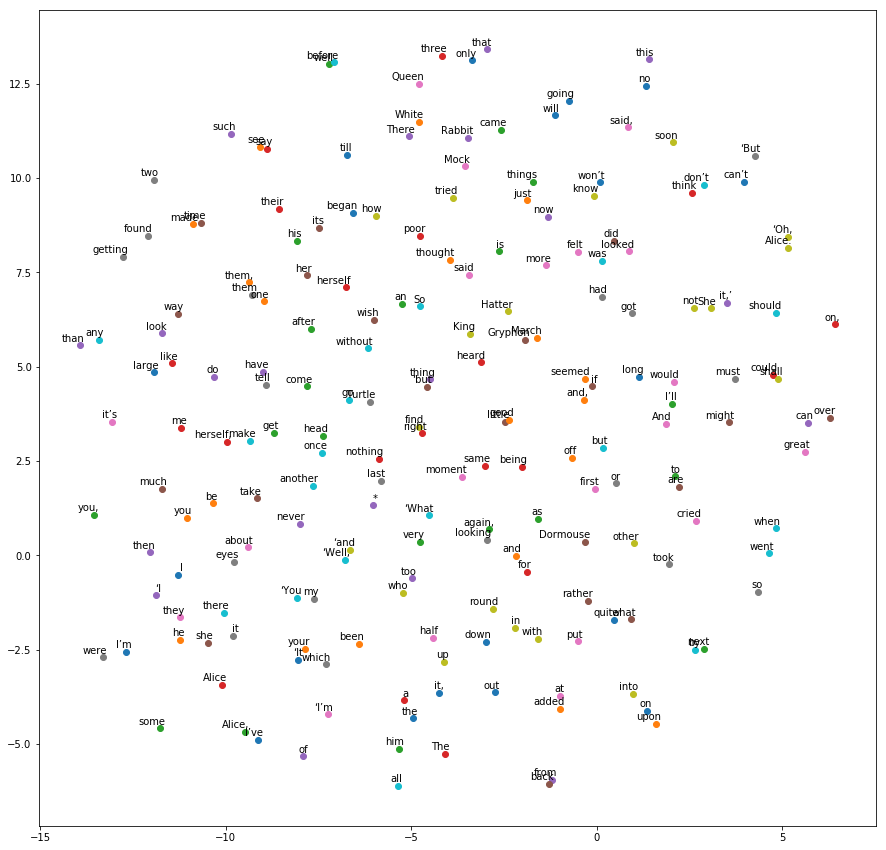

In [14]:
words = [index2word[i] for i in range(1, num_points+1)]

plot_data_point(two_d_embeddings, words)